In [43]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Load model and data for future

In [36]:
model = XGBRegressor()
model.load_model('../models/xgboost_model.ubj')

wind = pd.read_parquet('../future_data/wind.parquet')
consumption = pd.read_parquet('../future_data/consumption.parquet')

df = wind.join(consumption).tz_localize(tz='UTC')
df.tail()


,Wind_MWh,w_lag1,w_lag2,w_lag3,Consumption_MWh,c_lag1,c_lag2,c_lag3
2022-12-31 20:00:00+00:00,1641.641724,878.0,561.0,NaN,11641.276367,11561.0,10490.0,NaN
2022-12-31 21:00:00+00:00,1566.043701,703.0,583.0,NaN,11217.675781,11497.0,10318.0,NaN
2022-12-31 22:00:00+00:00,951.898865,512.0,572.0,1597.0,10164.972656,11075.0,9914.0,9950.0
2022-12-31 23:00:00+00:00,1354.330811,463.0,538.0,1514.0,10246.028320,10724.0,9535.0,9610.0
2023-01-01 00:00:00+00:00,1078.862183,601.0,547.0,1386.0,9447.356445,10473.0,9296.0,9408.0


#### Helper function to add time series features

In [37]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

### Predict the future!

In [46]:
NUMBER_OF_DAYS_TO_PREDICT = 30

In [47]:
now_ceil = pd.Timestamp.now(tz='UTC').ceil(freq='H')
date_range = pd.date_range(
        start=now_ceil, end=now_ceil+timedelta(days=NUMBER_OF_DAYS_TO_PREDICT), freq="H")
future_df = pd.DataFrame({'datetime': date_range}).set_index('datetime')
future_df = future_df.join(df)
future_df = create_features(future_df)


In [48]:
features = ['Wind_MWh','Consumption_MWh','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'c_lag1','c_lag2','c_lag3','w_lag1','w_lag2','w_lag3'] # These should be the same as used in modelling!!!
future_df['price'] = model.predict(future_df[features])

# Plot the price for the future!

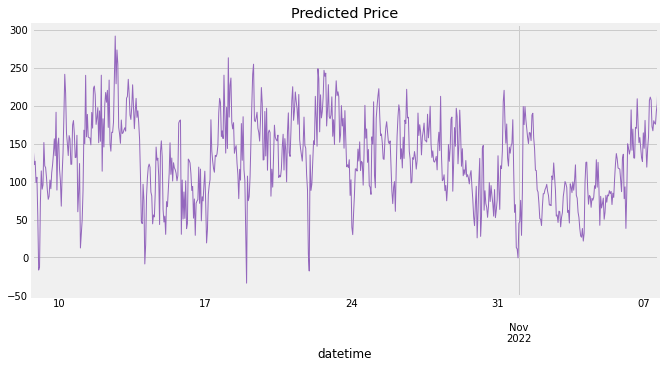

In [49]:
future_df['price'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Predicted Price')
plt.show()